In [1]:
import sys
sys.path.insert(0, f"/home/txm/gpu_txmdata/integration/package/v1.0/scMIAC/")

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
from scmiac.preprocess import run_umap,preprocessing_atac,run_lsi

# adata_rna

## gene expression

In [3]:
adata_rna = sc.read('/mdshare/node8/txmdata/scATAC_seq/AtacAnnoR/data/10X-Multiome/h5ad/RNA.h5ad')
adata_rna

AnnData object with n_obs × n_vars = 10412 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: 'features'

In [4]:
adata_rna.obs['modality'] = 'RNA'

## Run PCA

In [5]:
# normalize
sc.pp.normalize_total(adata_rna, target_sum=1e4)
sc.pp.log1p(adata_rna)
# select HVG
sc.pp.highly_variable_genes(adata_rna, n_top_genes=3000)
# Note: make sure the normalized expression matrix of all genes is in `.raw` attribute
adata_rna.raw = adata_rna.copy()
adata_rna = adata_rna[:, adata_rna.var['highly_variable']]
# scale
sc.pp.scale(adata_rna, max_value=10)
# pca
sc.tl.pca(adata_rna, n_comps=50)
# umap
adata_rna = run_umap(adata_rna,use_rep='X_pca')

/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


UMAP embedding is stored in adata.obsm['X_pca_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


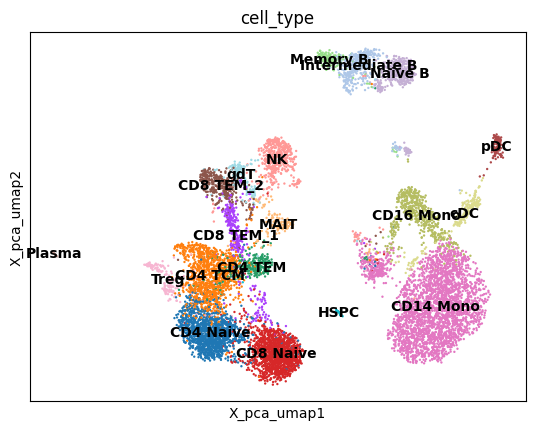

In [6]:
# UMAP based on gene expression
sc.pl.embedding(adata_rna, basis='X_pca_umap', color=['cell_type'],legend_loc = 'on data')

In [7]:
adata_rna.write("../../demo_data/adata_rna_10x.h5ad")

# adata_atac

## gene activity

In [8]:
adata_atac = sc.read('/mdshare/node8/txmdata/scATAC_seq/AtacAnnoR/data/10X-Multiome/h5ad/ATAC_GA.h5ad')
adata_atac

AnnData object with n_obs × n_vars = 10412 × 19607
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type'
    var: 'features'

In [9]:
adata_atac.obs['modality'] = 'ATAC'

In [10]:
# normalize
sc.pp.normalize_total(adata_atac, target_sum=1e4)
sc.pp.log1p(adata_atac)
# select HVG
sc.pp.highly_variable_genes(adata_atac, n_top_genes=3000)
# Note: make sure the normalized activity matrix of all genes is in `.raw` attribute
adata_atac.raw = adata_atac
adata_atac = adata_atac[:, adata_atac.var['highly_variable']]
# scale
sc.pp.scale(adata_atac, max_value=10)
# pca
sc.tl.pca(adata_atac, n_comps=50)
# umap
adata_atac = run_umap(adata_atac,use_rep='X_pca')

/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


UMAP embedding is stored in adata.obsm['X_pca_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


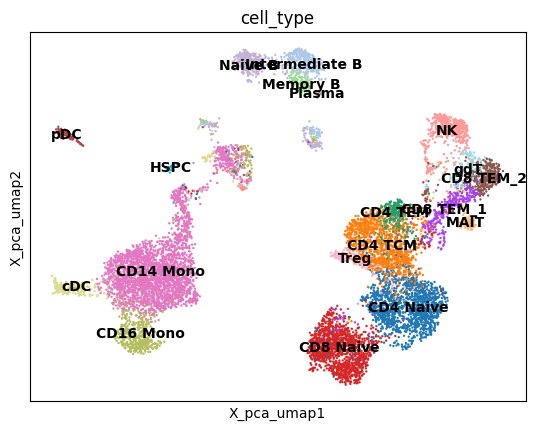

In [11]:
# UMAP based on gene activity
sc.pl.embedding(adata_atac, basis='X_pca_umap', color=['cell_type'],legend_loc = 'on data')

## peak counts

In [12]:
adata_peak = sc.read('/mdshare/node8/txmdata/DL/ATAC_code/20241023/data/10X-Multiome/adata_atac.h5ad')
adata_peak

AnnData object with n_obs × n_vars = 10412 × 108377
    obs: 'true'
    var: 'features'
    uns: 'neighbors', 'true_colors', 'umap'
    obsm: 'lsi', 'lsi49', 'lsi49_umap', 'lsi_umap', 'nmf', 'nmf_umap'
    obsp: 'connectivities', 'distances'

## Run LSI

In [13]:
adata_peak = preprocessing_atac(adata_peak, binary=True, n_top_peaks=None)
adata_peak = run_lsi(adata_peak,n_components=50,post_normalizing=True)

Raw dataset shape: (10412, 108377)
tfidf


/home/txm/gpu_txmdata/integration/package/v1.0/scMIAC/scmiac/preprocess.py:58: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)


normalizing
svd
post normalizing


In [14]:
adata_peak.obsm['lsi49'] = adata_peak.obsm['lsi'][:, 1:]

In [15]:
adata_atac.obsm['lsi49'] = adata_peak.obsm['lsi49'] 
adata_atac = run_umap(adata_atac,use_rep='lsi49')

UMAP embedding is stored in adata.obsm['lsi49_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


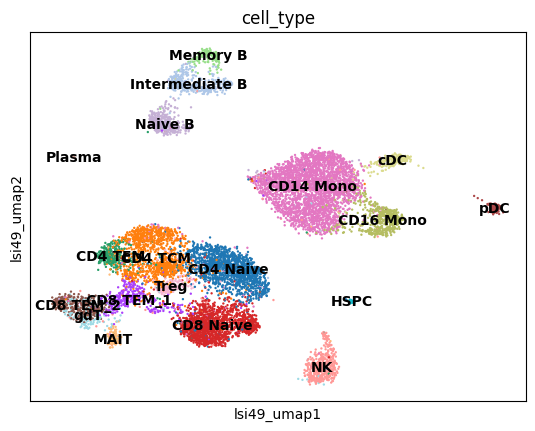

In [16]:
# UMAP based on chromatin accessibility
sc.pl.embedding(adata_atac , basis='lsi49_umap', color=['cell_type'],legend_loc = 'on data')

## Add cell type annotations

In [17]:
# Note: make sure the predicted cell type labels are in `.obs['pred']` attribute
cell_meta_file = "/mdshare/node8/txmdata/scATAC_seq/AtacAnnoR/data/10X-Multiome/AtacAnnoR_tmp_data/cell_meta.csv"
cell_meta = pd.read_csv(cell_meta_file)
adata_atac.obs['pred'] = cell_meta['final_pred'].values

In [18]:
adata_atac.write("../../demo_data/adata_atac_10x.h5ad")